
## A simple GAN to generate Images


In [1]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image



In [2]:

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split

from mlxtend.plotting import heatmap


In [3]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable



## Parameters


In [4]:

learning_rate    = 0.003  ## Adam default   ## 0.001
batch_size       = 32
N_Epochs         = 30  ##27000  



## Read the data


In [5]:

data_path = "data/MNISTdata/"


mnist_train = datasets.MNIST(data_path, train=True, download=True)


In [6]:

mnist_test = datasets.MNIST(data_path, train=False, download=True)


In [7]:

mnist_train_tr = datasets.MNIST(data_path, train=True, download=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))
mnist_test_tr  = datasets.MNIST(data_path, train=False, download=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor()
                                            ]))



## View the Images


In [8]:

Image.fromarray(  mnist_test_tr.data[333].numpy()  ) 


In [9]:

## mnist_train_tr.data = mnist_train_tr.data.view(60000, 1, 28, 28)

mnist_train_tr.data.shape


torch.Size([60000, 28, 28])


## Create Data Loaders


In [10]:

mnist_train_tr.data.shape


torch.Size([60000, 28, 28])

In [11]:

mnist_test_tr.data.shape


torch.Size([10000, 28, 28])

In [12]:

train_dl  = torch.utils.data.DataLoader(mnist_train_tr, batch_size=batch_size, shuffle=True  ) 
test_dl   = torch.utils.data.DataLoader(mnist_test_tr,  batch_size=batch_size, shuffle=False ) 



## Utility Functions


In [13]:

def plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked):
    
    the_epochs = [i for i in range(len(list_losses_real))]  

    plt.plot(the_epochs, list_losses_real,    label = "real") 
    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.plot(the_epochs, list_losses_tricked, label = "tricked")
    plt.legend() 
    plt.show()


In [14]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat 


In [15]:

def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()


In [16]:

def random_G_vector_input():
    rand_vec = torch.randn( 100 )
    return rand_vec


In [17]:

def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) )
    return rand_vec



## NN Architectures


In [18]:

## Deep Learning with 2 hidden layers

class DL_Net(nn.Module):
    
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(4, 15)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(15, 9)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(9, 3)
        self.act3    = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x      = (x - self.x_means) / self.x_deviations
        
        x      = self.linear1(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)
        
        return y_pred



In [19]:



class Generator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100, 256)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(256)
        self.linear2 = nn.Linear(256, 784)
        self.act2    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, rand_input ):
        

        x      = self.linear1( rand_input )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.linear2(x)
        x      = self.act2(x)
        y_pred = x
        
        return y_pred




In [20]:

class Generator_DL_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100, 60)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(60)
        self.linear2 = nn.Linear(60, 120)
        self.act2    = nn.LeakyReLU(0.02)
        self.norm2   = nn.LayerNorm(120)
        self.linear3 = nn.Linear(120, 784)
        self.act3    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, rand_input ):
        

        x      = self.linear1( rand_input )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.norm2(x) 
        x      = self.dropout(x)
        x      = self.linear3(x)
        x      = self.act3(x)
        
        y_pred = x
        
        return y_pred


In [21]:


class Discriminator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(784, 100)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(100, 50)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(50, 1)
        self.act3    = nn.Sigmoid()             ## nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x):
        
        x      = self.linear1(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)
        
        return y_pred





## Training Function


In [22]:

list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []
    

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:              ## xb = [batch, 1, 28, 28]
            
            xb = torch.squeeze(xb, dim=1)
            xb = xb.reshape((-1, 784))
            
            #################################################
            
            ## G_model.eval()     ## No G training
            
            ## gen_img = G_model( random_G_vector_input() )
            gen_img = G_model( random_G_batch_vector_input() ).detach()
            
            ## Train D with real data
            D_real_y_pred = D_model(  xb  )
            D_real_loss   = D_loss_fn( D_real_y_pred, torch.ones((batch_size, 1)) )
            D_opt.zero_grad()
            D_real_loss.backward()
            D_opt.step()
            
            ## Train D with fake data
            D_fake_y_pred = D_model(  gen_img  )
            D_fake_loss   = D_loss_fn( D_fake_y_pred, torch.zeros((batch_size, 1)))
            D_opt.zero_grad()
            D_fake_loss.backward()
            D_opt.step()
            
            ## G_model.train()    ## yes G training
            
            #################################################
            
            ## D_model.eval()     ## No D training
            
            ## gen_img = G_model( random_G_vector_input() )
            gen_img = G_model( random_G_batch_vector_input() )
            
            ## Train G with D_loss (need to trick D)
            D_tricked_y_pred = D_model(  gen_img  )
            D_tricked_loss   = D_loss_fn( D_tricked_y_pred, torch.ones((batch_size, 1)) )
            G_opt.zero_grad()
            D_tricked_loss.backward()
            G_opt.step()
            
            ## D_model.train()    ## yes D training
                        
       
            
        if epoch % 1 == 0:
            print("******************************")
            print(epoch, "D_real_loss=", D_real_loss)
            print(epoch, "D_fake_loss=", D_fake_loss)
            print(epoch, "D_tricked_loss=", D_tricked_loss)
            list_losses_real.append(        D_real_loss.detach().numpy()  )
            list_losses_fake.append(        D_fake_loss.detach().numpy()  )
            list_losses_tricked.append(  D_tricked_loss.detach().numpy()  )
            



## Core Functions


In [23]:


G_model     = Generator_Net()

## G_model     = Generator_DL_Net()

D_model     = Discriminator_Net()

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn   = nn.BCELoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate )

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )



******************************
0 D_real_loss= tensor(0.1157, grad_fn=<BinaryCrossEntropyBackward0>)
0 D_fake_loss= tensor(0.0114, grad_fn=<BinaryCrossEntropyBackward0>)
0 D_tricked_loss= tensor(7.8405, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
1 D_real_loss= tensor(0.2492, grad_fn=<BinaryCrossEntropyBackward0>)
1 D_fake_loss= tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
1 D_tricked_loss= tensor(5.4396, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
2 D_real_loss= tensor(0.1128, grad_fn=<BinaryCrossEntropyBackward0>)
2 D_fake_loss= tensor(0.0804, grad_fn=<BinaryCrossEntropyBackward0>)
2 D_tricked_loss= tensor(4.2457, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
3 D_real_loss= tensor(0.4684, grad_fn=<BinaryCrossEntropyBackward0>)
3 D_fake_loss= tensor(0.5861, grad_fn=<BinaryCrossEntropyBackward0>)
3 D_tricked_loss= tensor(1.4506, grad_fn=<BinaryCrossEntropyBackward0>)
******************************
4 D_r


## Plot Losses


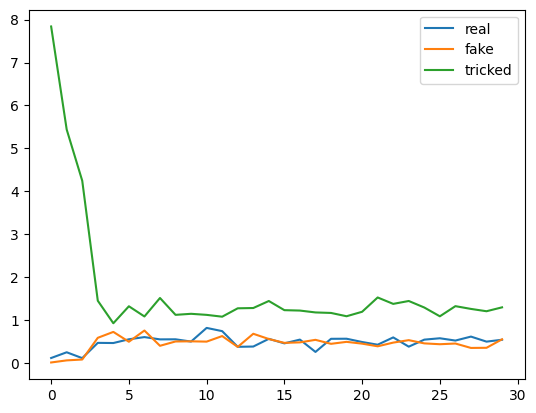

In [24]:

plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked)
            

In [25]:

## list_losses_real



## Test generating after training


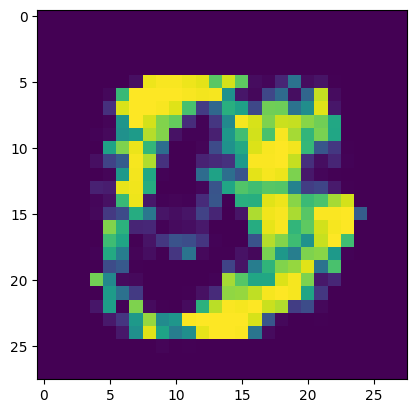

In [26]:

gen_test_img3 = G_model( random_G_vector_input() )
gen_test_img3 = gen_test_img3.reshape( (28,28) )
plt.imshow( gen_test_img3.detach().numpy() )
plt.show()


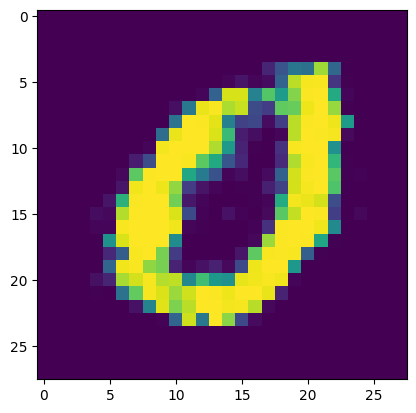

In [27]:

gen_test_img3 = G_model( random_G_vector_input() )
gen_test_img3 = gen_test_img3.reshape( (28,28) )
plt.imshow( gen_test_img3.detach().numpy() )
plt.show()


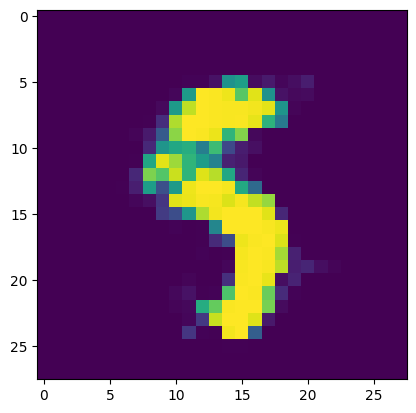

In [28]:

gen_test_img3 = G_model( random_G_vector_input() )
gen_test_img3 = gen_test_img3.reshape( (28,28) )
plt.imshow( gen_test_img3.detach().numpy() )
plt.show()


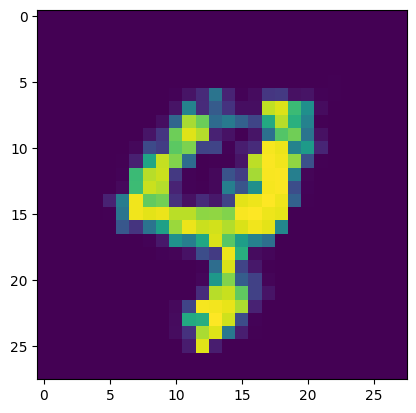

In [29]:

gen_test_img3 = G_model( random_G_vector_input() )
gen_test_img3 = gen_test_img3.reshape( (28,28) )
plt.imshow( gen_test_img3.detach().numpy() )
plt.show()


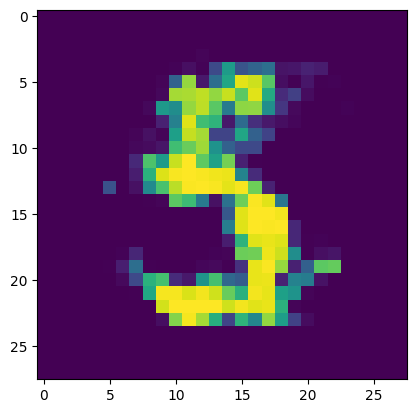

In [30]:

gen_test_img3 = G_model( random_G_vector_input() )
gen_test_img3 = gen_test_img3.reshape( (28,28) )
plt.imshow( gen_test_img3.detach().numpy() )
plt.show()



## Generator - Try out the Maths with dummy data


In [31]:

G_dummy     = Generator_Net()



In [32]:

gen_dummy_img = G_dummy( random_G_vector_input() )

gen_dummy_img.shape


torch.Size([784])

In [33]:

gen_dummy_img = gen_dummy_img.reshape( (28,28) )
gen_dummy_img.shape


torch.Size([28, 28])

In [34]:

   
## dummy_torch = torch.rand(3, 32, 32)    ## for rgb


transform_dummy = T.ToPILImage()

img = transform_dummy(gen_dummy_img)

img


In [35]:

gen_dummy_img.detach().numpy().shape


(28, 28)

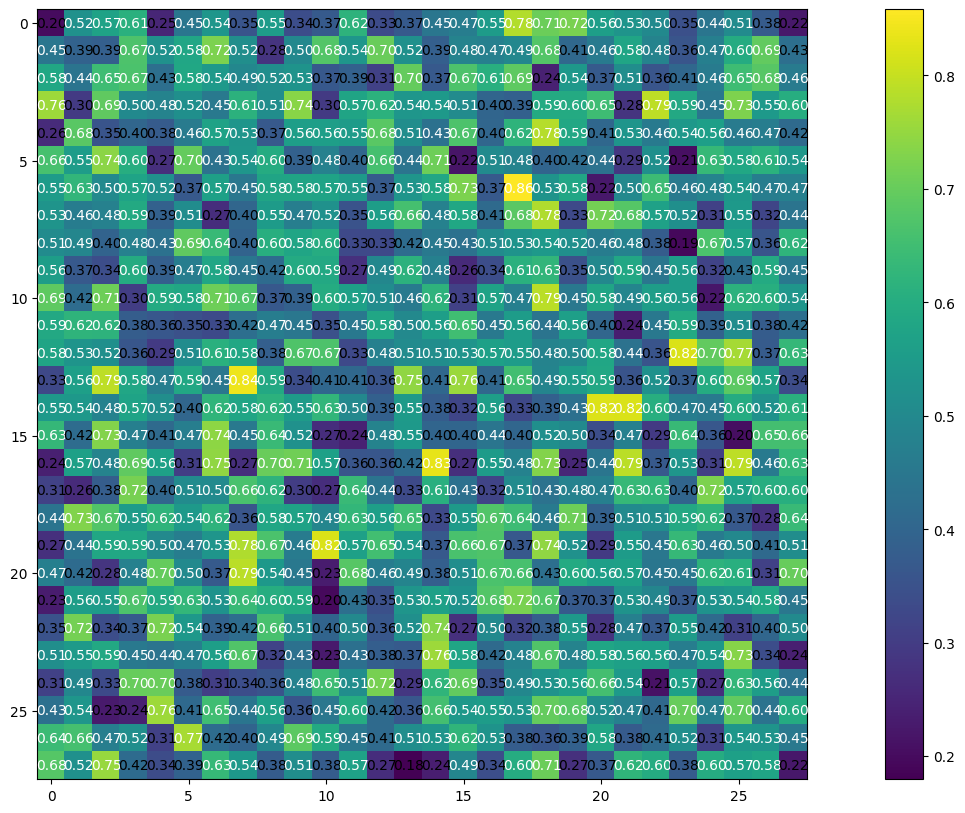

In [36]:

hm = heatmap(gen_dummy_img.detach().numpy(), figsize=(20,10))
plt.show()


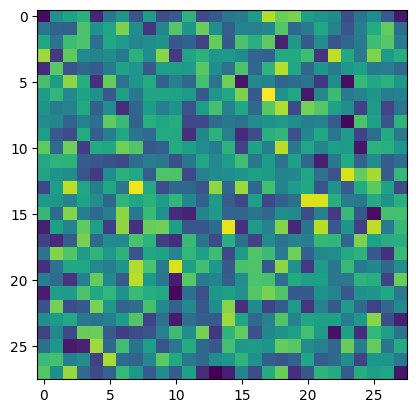

In [37]:

plt.imshow( gen_dummy_img.detach().numpy() )
plt.show()




## Discriminator - Try out the Maths with dummy data


In [38]:

D_dummy     = Discriminator_Net()


In [39]:

gen_dummy_img2 = G_dummy( random_G_vector_input() )

gen_dummy_img2.shape


torch.Size([784])

In [40]:

y_pred_dummy = D_dummy(     gen_dummy_img2     )


In [41]:

y_pred_dummy    ## Predicted label 0 or 1


tensor([0.5115], grad_fn=<SigmoidBackward0>)


## Test reshapes


In [42]:

batch_dummy_torch = torch.rand(64, 1, 28, 28)    
batch_dummy_torch.shape


torch.Size([64, 1, 28, 28])

In [43]:

batch_dummy_torch = torch.squeeze(batch_dummy_torch, dim=1)
batch_dummy_torch.shape


torch.Size([64, 28, 28])

In [44]:

batch_dummy_torch = batch_dummy_torch.reshape((-1, 784))
batch_dummy_torch.shape


torch.Size([64, 784])

In [45]:

label = torch.ones((8, 1))
label


tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [46]:

## label.item()
